<a href="https://colab.research.google.com/github/ydduri/Biology/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_6%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Diagnosis with Deep learning

### 1. 먼저 구글 드라이브에 마운트합니다.
구글 드라이브에 저장되어 있는 정보를 불러올 수 있습니다. 실행시키면 pop되는 링크에 들어가서 데이터를 넣은 구글 계정을 선택한 후에. Token을 복사해서 아래 네모칸에 붙여넣으면 됩니다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. 필요한 python library들을 import합니다. 
기본적인 numpy, pandas부터 딥러닝 특화 라이브러리인 tensorflow, 단순 머신러닝 특화 라이브러리인 scikit-learn까지 import합니다. 우리는 사진 정보를 다루므로, 시각화를 할 수 있는 matplotlib의 pyplot 모듈 또한 import합니다. 

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

### 3. 데이터 로딩과 EDA(Exploratory Data Analysis)
데이터를 pandas의 read_csv 매서드를 이용해 불러오고, pandas 내장 API들을 이용해 이리저리 탐험(EDA)합니다. 딥러닝을 본격적으로 시작하기 전에 이러한 EDA를 통해 데이터의 구조를 파악하면 신경망을 쌓을 때 참고할 수 있고, 적합한 pre-processing 과정을 진행할 수 있습니다. 머신러닝/딥러닝 전 EDA는 선택이 아닌 필수입니다. 

In [5]:
# 데이터를 불러옵니다. 
data = pd.read_csv('/content/drive/MyDrive/skin/hmnist_28_28_RGB.csv')

# 데이터의 가장 앞 5줄을 출력합니다. 뒤엣부분을 출력하고 싶으면 data.tail()을 입력하면 됩니다. 
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [6]:
# 데이터의 길이를 측정합니다. 
print(len(data)) # 10015

# 데이터의 모양을 측정합니다.
print(data.shape) # (10015, 2353) 아래로 10015길이, 오른쪽으로 2353 길이라는 뜻입니다. 

10015
(10015, 2353)


In [7]:
# 데이터의 맨 오른쪽에 있는 label을 추출합니다. 
Label = data.iloc[:, -1] # data.iloc[:, 2352]해도 같은 결과를 낼 수 있습니다. 

# 데이터의 맨 오른쪽을 제외한 
Data = data.iloc[:, 0:-1] # data.iloc[:, 0:2351] 해도 같은 결과를 낼 수 있습니다

In [8]:
# 각각의 label(skin cancer의 유형)이 몇 개 있는지 출력합니다. 
Label.value_counts() # 우리의 데이터는 7개 유형의 피부암 사진과 그 레이블된 데이터 유형으로 이루어져 있습니다. 

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

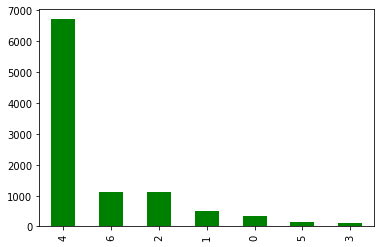

In [10]:
# 막대그래프로도 그릴 수 있습니다. 
Label.value_counts().plot.bar(color='green')

In [11]:
# Data의 모습입니다. 실제로 값들은 이렇게 2차원 배열로 생겼습니다. 
print(Data.values)

# 한 줄 띄기
print('\n')

# Data는 DataFrame 자료형이지만, Data.values는 numpyarray입니다. 
print(type(Data), type(Data.values))

[[192 153 193 ... 185 154 177]
 [ 25  14  30 ...  25  14  27]
 [192 138 153 ... 136 104 117]
 ...
 [132 118 118 ... 172 151 145]
 [160 124 146 ... 185 162 172]
 [175 142 121 ... 175 139 126]]


<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


### 4. Data Pre-processing 
데이터를 가공하여 기계가 학습하기 쉽도록 만듭니다. input shape을 (28, 28, 3)으로 맞출 예정입니다. 또한, train과 test dataset을 split하여 학습에 이용할 예정입니다. 이 과정은 scikit-learn의 sklearn.model_selection.train_test_split 매서드를 이용하면 됩니다. 

(기존에 딥러닝/머신러닝을 공부해 보셨던 분들은 Validation dataset이 없다는 점에서 의문을 품으실 수 있지만, 우리는 어디까지나 딥러닝 코딩을 한 번 해보는 것이 목적이므로 넘어가겠습니다.)

In [12]:
# numpyarray로 Data를 바꿔줌. tensorflow는 pandas DataFrame자체는 못 먹고, ndarray로 변환해 줘야 먹을 수 있음. 
Data = Data.values.reshape(-1, 28, 28, 3) # Datashape을 주의해서 볼 것. 28x28x3의 모양이 10015개 있음. 

Label = Label.values.reshape(-1) # 일차원 배열로 바꿔줌. 
print(Data[0, :, :])
print('\n---------------------------------------\n')
print(Label)

[[[192 153 193]
  [195 155 192]
  [197 154 185]
  ...
  [193 144 153]
  [197 154 163]
  [194 152 160]]

 [[197 162 202]
  [201 160 197]
  [202 160 193]
  ...
  [194 147 149]
  [198 158 166]
  [192 153 167]]

 [[197 155 193]
  [198 154 185]
  [202 156 191]
  ...
  [194 149 152]
  [199 161 177]
  [194 156 175]]

 ...

 [[194 157 191]
  [206 173 206]
  [206 165 192]
  ...
  [191 155 183]
  [193 159 187]
  [193 163 197]]

 [[187 154 185]
  [203 171 199]
  [202 161 183]
  ...
  [178 131 148]
  [187 152 174]
  [190 159 189]]

 [[171 136 164]
  [191 153 179]
  [196 155 176]
  ...
  [173 124 138]
  [183 147 166]
  [185 154 177]]]

---------------------------------------

[2 2 2 ... 0 0 6]


In [13]:
# sklearn.preprocessing 모듈을 이용해 Label을 one-hot encoding으로 만드는 작업. one-hot encoding에 대해서는 프리뷰 자료 참조할 것
from sklearn.preprocessing import LabelBinarizer
binencoder = LabelBinarizer() # 파이썬 언어의 특징. 객체 지향 언어인 파이썬에서는 뒤에 ()를 붙이면 함수 또는 클래스, 안 붙이면 그냥 매서드임. 
Label = binencoder.fit_transform(Label) # 
print(Label)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


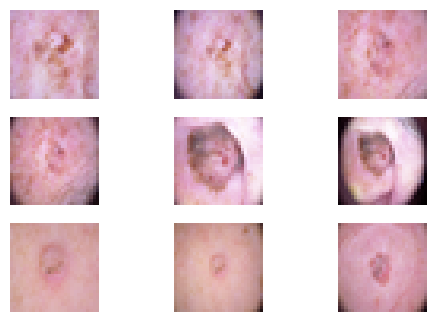

In [14]:
# 피부암 이미지를 보자. 사실 EDA 에 속하긴 하지만 그래도 꼭 봐야 하기 때문에 괜찮다
plt.figure(dpi=100) # 이미지의 크기를 지정
for i in range(9):
  plt.subplot(3, 3, i+1).axis('off')
  plt.imshow(Data[i])

In [15]:
# 위에서 언급했던 train data와 test data의 split을 시행합니다. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data, Label, test_size=0.2, random_state=33)

In [16]:
# train과 test의 split된 형태를 확인해 봅니다. 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8012, 28, 28, 3) (8012, 7)
(2003, 28, 28, 3) (2003, 7)


In [17]:
# Deep learning에서 backpropagation이 일어날 때 자동미분이 일어나기 때문에 값이 큰 것 보다는 정규화되어 있는 것이 유리합니다. 
# 따라서 input data들을 255로 나눠 정규화해 줍니다. 
X_train, X_test = X_train / 255, X_test / 255

# 딥러닝과 머신러닝에서는 input data의 shape가 중요하기 때문에 집어넣기 전 마지막으로 shape를 확인해 주는 것이 좋습니다. 
X_train = X_train.reshape(-1, 28, 28, 3).astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 3).astype(np.float32)

### 5. Building Neural Network
드디어 신경망을 쌓아봅시다! 저희는 이제부터 두 개의 신경망(MLP, CNN)을 쌓고 성능을 비교해 볼 겁니다. 

In [18]:
def MLP(input_shape=(None, None, 3), dropout_rate=0.2):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=input_shape))
  model.add(tf.keras.layers.Dense(units=400, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
  model.add(tf.keras.layers.Dense(units=7, activation='relu'))
  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [19]:
def CNN(input_shape=(None, None, 3), dropout_rate=0.2):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), input_shape=input_shape, activation='relu'))
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(2, 2), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Dense(units=7, activation='relu'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [20]:
model_MLP = MLP(input_shape = (28, 28, 3))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 400)               941200    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 982,007
Trainable params: 982,007
Non-trainable params: 0
_________________________________________________________________


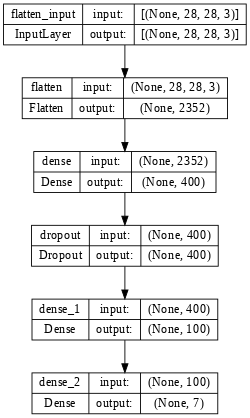

In [21]:
model_MLP.summary()
tf.keras.utils.plot_model(model_MLP, show_shapes = True, dpi=64)

In [22]:
model_CNN = CNN(input_shape=(28, 28, 3))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 128)       1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       131328    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 256)      0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 43264)             0         
                                                                 
 dropout_1 (Dropout)         (None, 43264)             0         
                                                                 
 dense_3 (Dense)             (None, 7)                 302855    
                                                      

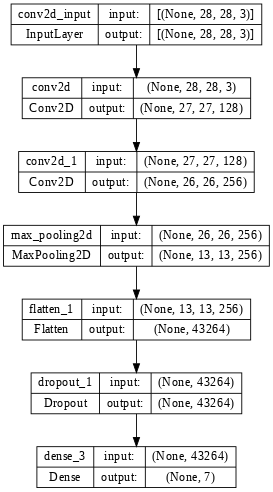

In [23]:
model_CNN.summary()
tf.keras.utils.plot_model(model_CNN, show_shapes=True, dpi=64)

### 6. 신경망 학습
드디어 신경망이 학습합니다. 런타임을 GPU로 설정하면 훨씬 빠르게 학습할 수 있습니다. CNN이 파라미터의 수가 훨씬 많은 만큼, 학습에 더 오랜 시간이 걸립니다. 

In [24]:
print("MLP")
history_MLP = model_MLP.fit(X_train, y_train, epochs=15, verbose=1)
print("\nCNN")
history_CNN = model_CNN.fit(X_train, y_train, epochs=15, verbose=1)

MLP
Epoch 1/15
251/251 [==============================] - 3s 3ms/step - loss: 3.0348 - acc: 0.6254
Epoch 2/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3388 - acc: 0.6736
Epoch 3/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3191 - acc: 0.6736
Epoch 4/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3066 - acc: 0.6736
Epoch 5/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3499 - acc: 0.6648
Epoch 6/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3243 - acc: 0.6736
Epoch 7/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3051 - acc: 0.6736
Epoch 8/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3695 - acc: 0.6730
Epoch 9/15
251/251 [==============================] - 1s 3ms/step - loss: 2.3234 - acc: 0.6736
Epoch 10/15
251/251 [==============================] - 1s 3ms/step - loss: 2.1302 - acc: 0.6732
Epoch 11/15
251/251 [========================

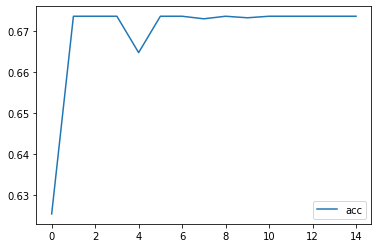

In [25]:
history_MLP_df = pd.DataFrame(history_MLP.history)
history_MLP_df.loc[:, ['acc']].plot()

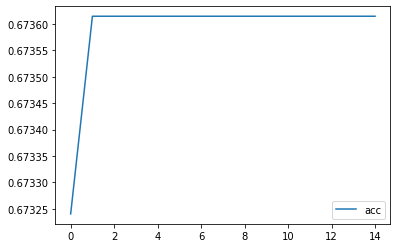

In [26]:
history_CNN_df = pd.DataFrame(history_CNN.history)
history_CNN_df.loc[:, ['acc']].plot()

In [ ]:
model_MLP.evaluate()
model_CNN.evaluate()